# Código de la P3: Clasificación
## Ignacio Garach Vélez 

En primer lugar cargaremos los datos desde fichero:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score

plt.rcParams["figure.figsize"] = (7, 5)

Cargamos los datos:

In [2]:
data = pd.read_csv('datos/clasificacion/bank-full.csv', sep = ';')
values = data.values
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
values

array([[58, 'management', 'married', ..., 0, 'unknown', 'no'],
       [44, 'technician', 'single', ..., 0, 'unknown', 'no'],
       [33, 'entrepreneur', 'married', ..., 0, 'unknown', 'no'],
       ...,
       [72, 'retired', 'married', ..., 3, 'success', 'yes'],
       [57, 'blue-collar', 'married', ..., 0, 'unknown', 'no'],
       [37, 'entrepreneur', 'married', ..., 11, 'other', 'no']],
      dtype=object)

Exploremos los datos:

In [4]:
print(data.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


Consultamos las variables categóricas y se observa variabilidad y pese a los desconocidos han de tenerse en cuenta, optaremos por realizarles OneHot Encoding, en la memoria ampliaré los motivos:

In [5]:
data.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [6]:
data.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [7]:
data.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [8]:
data.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [9]:
data.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

Las clases no estan balanceadas, esto es necesario tenerlo en cuenta:

In [10]:
data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Mapeamos las variables binarias a $\{0, 1\}$

In [11]:
binaries = ['default', 'housing', 'loan', 'y']
for b in binaries:
    data[b] = data[b].map({'yes':1 ,'no':0}) 

Definimos esta función para generar las columnas que producen el OneHotEncoding y eliminamos las anteriores:

In [12]:
def onehotencode(data, feature):
    dummies = pd.get_dummies(data[[feature]])
    res = pd.concat([data, dummies], axis=1)
    res = res.drop([feature], axis=1)
    return(res) 

In [13]:
categorical = ['job', 'marital', 'education', 'contact', 'poutcome']
for c in categorical:
    data = onehotencode(data, c)

Ahora debemos lidiar con los datos temporales, para que se entiendan de forma cíclica le aplicaremos transformaciones seno y coseno, se amplia en la memoria:

In [14]:
months = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may' : 5, 'jun':6, 'jul' : 7, 'aug' : 8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
data.month = data.month.map(months)

Para ello usaremos estas funciones tomadas de la documentación oficial de scikitlearn:

In [15]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [16]:
data["day_sin"] = sin_transformer(31).fit_transform(data)["day"]
data["day_cos"] = cos_transformer(31).fit_transform(data)["day"]
data["month_sin"] = sin_transformer(12).fit_transform(data)["month"]
data["month_cos"] = cos_transformer(12).fit_transform(data)["month"]
data = data.drop(["day"], axis=1)
data = data.drop(["month"], axis=1)

In [17]:
target = np.array(data.loc[: , 'y'])
data = data.drop(["y"], axis=1)
target

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [18]:
x = data.to_numpy()

Vamos a separar los datos para llevar a cabo una observación más profunda sin caer en el data snooping/leakage:

In [19]:
x_train, x_test, y_train, y_test = train_test_split(
    x, target,
    test_size= 0.2,
    shuffle = True, stratify = target,
    random_state=1)

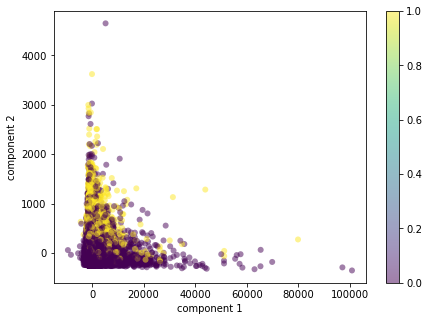

In [20]:
pca = PCA(2)  # project from 64 to 2 dimensions
pc = pca.fit_transform(x_train)
plt.scatter(pc[:, 0], pc[:, 1],
            c=y_train, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Llevaremos a cabo ahora un análisis de outliers mediante la técnica de IsolationForest, más info en memoria:

In [21]:
out = IsolationForest(n_estimators = 200, contamination=0.05, random_state=1)
out.fit(x_train)
liers = out.predict(x_train)
(liers==1).sum()

34359

In [22]:
index=[]
for i in range(len(liers)):
    if liers[i]==-1:
        index.append(i)
x_train = np.delete(x_train, index, axis=0)
y_train = np.delete(y_train, index, axis=0)

In [23]:
len(x_train), len(y_train)

(34359, 34359)

In [24]:
(liers == -1)

array([False, False, False, ..., False, False, False])

In [25]:
x

array([[ 5.80000000e+01,  0.00000000e+00,  2.14300000e+03, ...,
         5.28964010e-01,  5.00000000e-01, -8.66025404e-01],
       [ 4.40000000e+01,  0.00000000e+00,  2.90000000e+01, ...,
         5.28964010e-01,  5.00000000e-01, -8.66025404e-01],
       [ 3.30000000e+01,  0.00000000e+00,  2.00000000e+00, ...,
         5.28964010e-01,  5.00000000e-01, -8.66025404e-01],
       ...,
       [ 7.20000000e+01,  0.00000000e+00,  5.71500000e+03, ...,
        -9.54139256e-01, -5.00000000e-01,  8.66025404e-01],
       [ 5.70000000e+01,  0.00000000e+00,  6.68000000e+02, ...,
        -9.54139256e-01, -5.00000000e-01,  8.66025404e-01],
       [ 3.70000000e+01,  0.00000000e+00,  2.97100000e+03, ...,
        -9.54139256e-01, -5.00000000e-01,  8.66025404e-01]])

Obtenemos estadísticas de la población, a primera vista no hay variabilidades tremendamente bajas así que no eliminaremos variables:

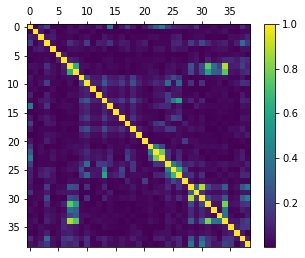

In [26]:
corr = np.abs(np.corrcoef(x_train, rowvar=False))
plt.matshow(corr, cmap='viridis')
plt.colorbar(shrink=0.8)

In [27]:
print(pd.DataFrame(x_train).describe().T)

      count         mean          std          min         25%           50%  \
0   34359.0    40.751157    10.248749    18.000000   33.000000  3.900000e+01   
1   34359.0     0.017288     0.130344     0.000000    0.000000  0.000000e+00   
2   34359.0  1304.869554  2937.782259 -8019.000000   68.000000  4.350000e+02   
3   34359.0     0.558893     0.496527     0.000000    0.000000  1.000000e+00   
4   34359.0     0.156204     0.363054     0.000000    0.000000  0.000000e+00   
5   34359.0   254.246806   249.721456     0.000000  103.000000  1.780000e+02   
6   34359.0     2.776827     3.138593     1.000000    1.000000  2.000000e+00   
7   34359.0    31.363777    89.945182    -1.000000   -1.000000 -1.000000e+00   
8   34359.0     0.366745     1.220706     0.000000    0.000000  0.000000e+00   
9   34359.0     0.117524     0.322048     0.000000    0.000000  0.000000e+00   
10  34359.0     0.220757     0.414763     0.000000    0.000000  0.000000e+00   
11  34359.0     0.033063     0.178803   

Estandarización:

In [28]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [29]:
pca = PCA(n_components=0.95)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

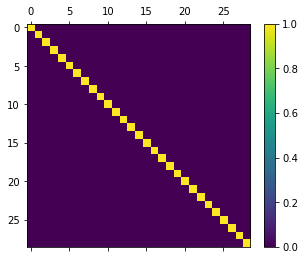

In [30]:
corr = np.abs(np.corrcoef(x_train, rowvar=False))
plt.matshow(corr, cmap='viridis')
plt.colorbar(shrink=0.8)

In [31]:
x_train

array([[-1.01962546,  0.39519016, -0.88836377, ...,  2.13807325,
         1.88744722,  0.98820462],
       [-1.22920173,  0.47731844,  0.50641821, ...,  0.10700121,
         0.30693877,  0.53996363],
       [-1.68557586, -1.9171022 ,  0.01319554, ...,  0.93606417,
         0.24278096,  0.92358995],
       ...,
       [-1.48810016, -1.72208569, -0.41669405, ...,  0.23596303,
        -0.11992899, -0.31031496],
       [-0.32047306,  0.23379458,  2.12219794, ..., -0.04568562,
        -0.70974007,  1.22449672],
       [ 4.68613775, -2.10570573,  1.54835465, ..., -0.67079342,
         2.82291743, -0.21119091]])

In [32]:
print(pd.DataFrame(x_train).describe().T)

      count          mean       std       min       25%       50%       75%  \
0   34359.0  1.197990e-15  1.957872 -3.037139 -1.359343 -0.363206  0.050568   
1   34359.0  1.892604e-15  1.672475 -5.129091 -1.373394 -0.052351  1.104201   
2   34359.0 -1.772790e-16  1.567726 -4.302827 -1.262974  0.169227  1.029489   
3   34359.0  1.303437e-15  1.424096 -3.362414 -1.062784 -0.025575  0.981111   
4   34359.0 -1.990656e-16  1.228943 -2.653556 -0.852867 -0.269678  0.705472   
5   34359.0 -5.440332e-16  1.217377 -4.498520 -0.843266 -0.162210  0.670807   
6   34359.0  8.145465e-16  1.156472 -4.264915 -0.483431  0.033155  0.514879   
7   34359.0 -1.172891e-15  1.110023 -7.887709 -0.694872 -0.065558  0.653902   
8   34359.0  6.591980e-17  1.085005 -8.170585 -0.439454  0.003314  0.436380   
9   34359.0  2.654097e-15  1.079774 -4.784757 -0.611375  0.067820  0.732824   
10  34359.0 -1.179128e-15  1.078191 -4.541594 -0.702081  0.002960  0.709706   
11  34359.0  1.611605e-15  1.059368 -3.607446 -0.562

In [33]:
def informeResultados(model, xt, yt):
    print("El accuracy obtenido por este modelo es :" + str(model.score(xt, yt)))
    print("El f1 score que combina precision & recall obtenido por este modelo es :" + str(f1_score(yt, model.predict(xt))))
    print("Los hiperparámetros estimados mediante GridSearch Cross Validation han sido:")
    print(model.best_params_)
    cf_matrix = confusion_matrix(yt, model.predict(xt))

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Matriz de confusión\n\n');
    ax.set_xlabel('\nPredicciones')
    ax.set_ylabel('Valores reales ');

    ax.xaxis.set_ticklabels(['no','yes'])
    ax.yaxis.set_ticklabels(['no','yes'])

In [34]:
parameters = [{'penalty':['l1','l2'],'alpha':[0.1,0.01,0.001,0.0001],'tol':[1e-3,1e-4,1e-6]}]
perceptron = Perceptron(random_state=1,max_iter=10000)
PLAmodel = GridSearchCV(perceptron, parameters, cv=5, scoring='accuracy', return_train_score=True)
PLAmodel.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Perceptron(max_iter=10000, random_state=1),
             param_grid=[{'alpha': [0.1, 0.01, 0.001, 0.0001],
                          'penalty': ['l1', 'l2'],
                          'tol': [0.001, 0.0001, 1e-06]}],
             return_train_score=True, scoring='accuracy')

El accuracy obtenido por este modelo es :0.8830034280659074
El f1 score que combina precision & recall obtenido por este modelo es :0.0
Los hiperparámetros estimados mediante GridSearch Cross Validation han sido:
{'alpha': 0.1, 'penalty': 'l1', 'tol': 0.001}


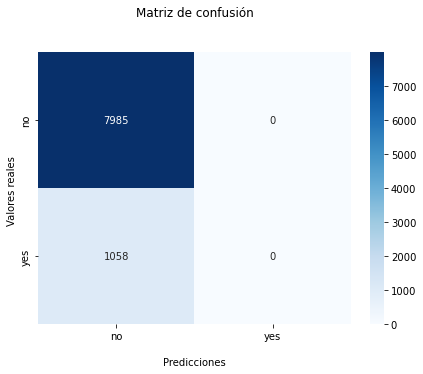

In [35]:
informeResultados(PLAmodel, x_test, y_test)

In [36]:
parameters = [{'penalty':['l2'],'C':[1,10,100,1000,10000]}]
logit = LogisticRegression(random_state=1,max_iter=1000)
LRmodel = GridSearchCV(logit, parameters, cv=5, scoring='accuracy', return_train_score=True)
LRmodel.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=1),
             param_grid=[{'C': [1, 10, 100, 1000, 10000], 'penalty': ['l2']}],
             return_train_score=True, scoring='accuracy')

El accuracy obtenido por este modelo es :0.8982638504920933
El f1 score que combina precision & recall obtenido por este modelo es :0.4403892944038929
Los hiperparámetros estimados mediante GridSearch Cross Validation han sido:
{'C': 1, 'penalty': 'l2'}


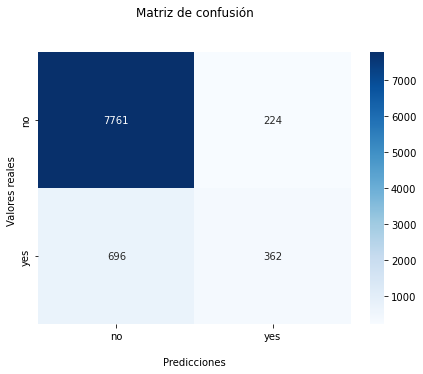

In [37]:
informeResultados(LRmodel, x_test, y_test)

In [38]:
parameters = [{'alpha':[0.1,0.01,0.001,0.0001]}]
lin = RidgeClassifier(random_state=2,max_iter=10000)
lineal = GridSearchCV(lin, parameters, cv=5, scoring='accuracy', return_train_score=True)
lineal.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RidgeClassifier(max_iter=10000, random_state=2),
             param_grid=[{'alpha': [0.1, 0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy')

El accuracy obtenido por este modelo es :0.8952781156695787
El f1 score que combina precision & recall obtenido por este modelo es :0.37491749174917494
Los hiperparámetros estimados mediante GridSearch Cross Validation han sido:
{'alpha': 0.1}


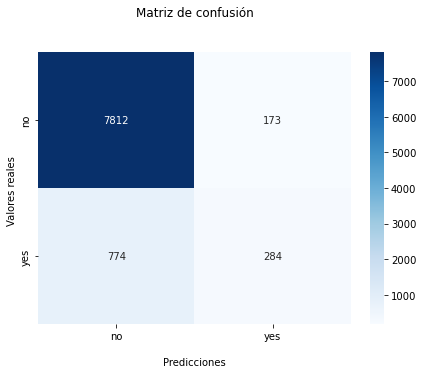

In [39]:
informeResultados(lineal, x_test, y_test)

El accuracy obtenido por este modelo es :0.8830034280659074
Los hiperparámetros estimados mediante GridSearch Cross Validation han sido:


[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

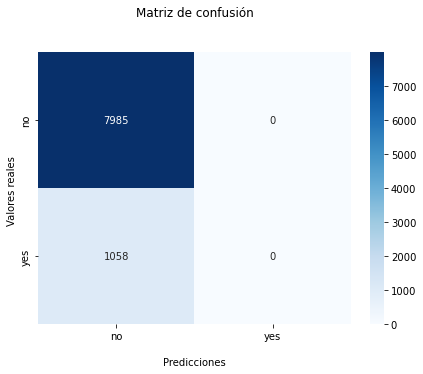

In [40]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_train, y_train)
print("El accuracy obtenido por este modelo es :" + str(dummy.score(x_test, y_test)))
print("Los hiperparámetros estimados mediante GridSearch Cross Validation han sido:")
cf_matrix = confusion_matrix(y_test, dummy.predict(x_test))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Matriz de confusión\n\n');
ax.set_xlabel('\nPredicciones')
ax.set_ylabel('Valores reales ');

ax.xaxis.set_ticklabels(['no','yes'])
ax.yaxis.set_ticklabels(['no','yes'])

El que mejor funciona parece ser regresión logística:

In [49]:
atest = LRmodel.score(x_test, y_test)
atest

0.8982638504920933

In [50]:
acv = LRmodel.best_score_
acv

0.907360561479817

Introducimos la función para el cálculo de curvas de aprendizaje https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [43]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ignan\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

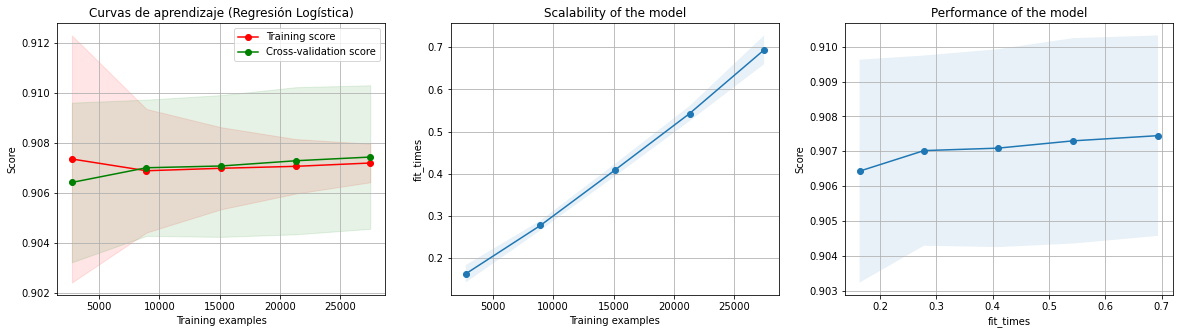

In [44]:
title = "Curvas de aprendizaje (Regresión Logística)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

plot_learning_curve(LRmodel, title, x_train, y_train, cv=cv)

Calculamos la cota mediante la desigualdad de Hoeffding:

In [51]:
delta = 0.05
def cotatest(error, N):
    return error + np.sqrt(np.log(2/delta)/(2*N))

cotatest(1-atest, len(x_test))

0.11601772002158489

In [53]:
1-acv

0.09263943852018297